# Benchmark Flax Models with APEBench

While foreign models cannot use advanced features of APEBench like correction
setups or differentiable physics training, it is still possible to benchmark
their performance on purely data-driven supervised learning tasks. This usually
follows a four-step pattern:

1. Scrape the training data trajectories and the test initial conditions from
   the APEBench scenario.
2. Use the training data trajectories to train the foreign model. (Or use a
   pretrained model.)
3. Rollout the foreign model for `scenario.test_temporal_horizon` steps from the
   test initial conditions.
4. Plug the resulting neural trajectories into
   `scenario.perform_tests_on_rollout` method to obtain a dictionary with the
   error rollouts according to all `scenario.report_metrics`.

Note that the step from (1.) -> (2.) can require a change in array format or
moving arrays to a different framework. So does step (3.) -> (4.).

This notebook uses the popular [Flax](https://github.com/google/flax) library in
JAX with its new [nnx](https://flax.readthedocs.io/en/latest/why.html) API.
Benchmarking such models is easy because we can keep JAX arrays. Still, we have
to account for Flax's [channels last convention on Conv
layers](https://flax.readthedocs.io/en/latest/why.html).

In [1]:
import apebench

import numpy as np
import jax
import jax.numpy as jnp
from flax import nnx
from tqdm.autonotebook import tqdm
import optax
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

/home/koehler/miniconda3/envs/apebench_dev/lib/python3.12/site-packages/trainax/_general_trainer.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## 1. Create Data with APEBench

As an example, we will use an advection scenario in difficulty mode with mostly
default settings.

In [2]:
advection_scenario = apebench.scenarios.difficulty.Advection(
    # A simple optimization setup that will be mimicked by Flax
    optim_config="adam;10_000;constant;1e-4",
    # The default metric for APEBench scenarios is always `"mean_nRMSE"`. Let's
    # add some more metrics to the report. One based on the spectrum up until
    # (including) the fifth mode and a Sobolev-based metric that also considers
    # the first derivative.
    report_metrics="mean_nRMSE,mean_fourier_nRMSE;0;5;0,mean_H1_nRMSE",
)

Create train **trajectories** and test **initial conditions** with APEBench.

In [3]:
train_data = advection_scenario.get_train_data()
test_ic_set = advection_scenario.get_test_ic_set()
train_data.shape, test_ic_set.shape

((50, 51, 1, 160), (30, 1, 160))

## 2. Train `flax.nnx` model

### Rearrange data
We have to rearrange our data to have the channels last convention

In [4]:
train_data = np.moveaxis(train_data, -2, -1)
test_ic_set = np.moveaxis(test_ic_set, -2, -1)
train_data.shape, test_ic_set.shape

((50, 51, 160, 1), (30, 160, 1))

### Data preprocessing

From here on, you are free to do with the `train_data` what you what. The
simplest approach would be **one-step supervised learning**. For this, we slice
windows of length two across both the trajectory and the time axis.

In [5]:
substacked_data = jax.vmap(apebench.exponax.stack_sub_trajectories, in_axes=(0, None))(
    train_data, 2
)
substacked_data.shape

(50, 50, 2, 160, 1)

Then, we can merge sample and window axis into a joint batch axis.

In [6]:
train_windows = jnp.concatenate(substacked_data)
train_windows.shape

(2500, 2, 160, 1)

### Model Definition

Just a simple ReLU feedforward ConvNet.

In [7]:
class CNN(nnx.Module):
    def __init__(self, width: int, depth: int, *, rngs: nnx.Rngs):
        self.conv_lift = nnx.Conv(
            1, width, kernel_size=(3,), padding="CIRCULAR", rngs=rngs
        )
        self.convs = [
            nnx.Conv(width, width, kernel_size=(3,), padding="CIRCULAR", rngs=rngs)
            for _ in range(depth - 1)
        ]
        self.conv_prj = nnx.Conv(
            width, 1, kernel_size=(3,), padding="CIRCULAR", rngs=rngs
        )

    def __call__(self, x):
        x = self.conv_lift(x)
        x = jax.nn.relu(x)
        for conv in self.convs:
            x = conv(x)
            x = jax.nn.relu(x)
        x = self.conv_prj(x)
        return x

### Training Loop

Inspired by the [nnx MNIST tutorial](https://flax.readthedocs.io/en/latest/mnist_tutorial.html#train-and-evaluate-the-model).

Access the attributes of the APEBench scenario to use the same hyperparameters.

In [8]:
cnn = CNN(width=34, depth=10, rngs=nnx.Rngs(0))
opt = nnx.Optimizer(cnn, optax.adam(1e-4))

metr = nnx.MultiMetric(
    loss=nnx.metrics.Average("loss"),
)


def one_step_supservised_loss(model: CNN, batch):
    inputs, targets = batch[:, 0], batch[:, 1]
    predictions = model(inputs)
    return jnp.mean((predictions - targets) ** 2)


@nnx.jit
def train_step(model: CNN, optimizer: nnx.Optimizer, metrics, batch):
    loss, grad = nnx.value_and_grad(one_step_supservised_loss)(model, batch)
    metrics.update(loss=loss)
    optimizer.update(grad)


loss_history = []
# Uses a simple infinite dataloader that does as many epochs as necessary
for batch in tqdm(
    apebench.pdequinox.cycling_dataloader(
        train_windows,
        batch_size=advection_scenario.batch_size,  # 20
        num_steps=advection_scenario.num_training_steps,  # 10_000
        key=jax.random.PRNGKey(42),
    )
):
    train_step(cnn, opt, metr, batch)
    for metric, value in metr.compute().items():
        loss_history.append(value)
    metr.reset()

10000it [00:39, 255.96it/s]


Let's visualize the loss history. It's a bit noisy towards the end, but let's
stick with a constant learning rate for simplicity.

Text(0, 0.5, 'Train Loss')

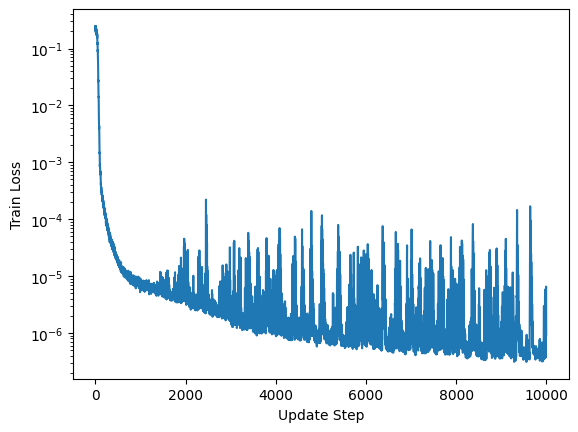

In [9]:
plt.semilogy(loss_history)
plt.xlabel("Update Step")
plt.ylabel("Train Loss")

## 3. Rollout the model

Rolling out the model requires calling it autoregressively, i.e., feeding it
based on its own output. This can be done by appending to a list and then
calling `jnp.stack`. However, it is more efficient to use `jax.lax.scan` which
is wrapped by `exponax.rollout`.

⚠️ The neural rollout must be **without** the initial conditions.

In [10]:
neural_rollout = apebench.exponax.rollout(
    cnn,
    advection_scenario.test_temporal_horizon,  # 200
)(test_ic_set)
neural_rollout.shape

(200, 30, 160, 1)

## 4. Perform tests on the rollout

### Rearrange data

Requires to change channel and spatial axes. APEBench also follows the
convention that the zeroth axis is the batch axis, and the next axis is for the
temporal snapshots. This must also be adjusted.

In [11]:
# Change to format (batch, time, channels, spatial)
neural_rollout = np.moveaxis(neural_rollout, 0, 1)
neural_rollout = np.moveaxis(neural_rollout, -1, -2)
neural_rollout.shape

(30, 200, 1, 160)

### Perform tests

Our `neural_rollout` is now of a format supported by `scenario.perform_tests_on_rollout`.

In [12]:
test_dict = advection_scenario.perform_tests_on_rollout(neural_rollout)

Now we find the same keys in the `test_dict` as set up for the `report_metrics`

In [13]:
test_dict.keys(), advection_scenario.report_metrics

(dict_keys(['mean_nRMSE', 'mean_fourier_nRMSE;0;5;0', 'mean_H1_nRMSE']),
 'mean_nRMSE,mean_fourier_nRMSE;0;5;0,mean_H1_nRMSE')

For each key, there is an array attached. It is of the shape `(num_seeds,
test_temporal_horizon)`. Since, the `neural_rollout` did not have a leading
`num_seeds` axis, this axis appears as singleton. The axis thereafter is due to
the 200 time steps performed in the test.

In [14]:
for key, value in test_dict.items():
    print(f"{key}: {value.shape}")

mean_nRMSE: (1, 200)
mean_fourier_nRMSE;0;5;0: (1, 200)
mean_H1_nRMSE: (1, 200)


### Rollout metrics

Let's visualize the error over time. Metrics with a full spectrum, even more so
the metric with derivatives (`"mean_H1_nRMSE"`) are worse, likely because
**nonlinear** networks applied to linear time stepping problems produce spurious
energy in higher modes. This is problematic since linear PDEs on periodic BCs
remain bandlimited.

However, this is not a problem of `flax.nnx` but a general problem of neural
emulators for linear PDEs. Hence, let's just acknowledge that the model performs
reasonable for at least ~50 time steps which is remarkable since it was only
trained to predict one step into the future and never multiple steps
autoregressively.

(-0.1, 1.1)

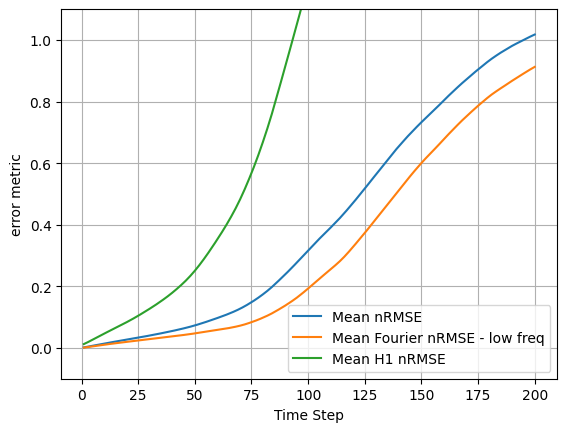

In [15]:
time_steps = jnp.arange(1, advection_scenario.test_temporal_horizon + 1)
plt.plot(
    time_steps,
    test_dict["mean_nRMSE"][0],
    label="Mean nRMSE",
)
plt.plot(
    time_steps,
    test_dict["mean_fourier_nRMSE;0;5;0"][0],
    label="Mean Fourier nRMSE - low freq",
)
plt.plot(
    time_steps,
    test_dict["mean_H1_nRMSE"][0],
    label="Mean H1 nRMSE",
)
plt.xlabel("Time Step")
plt.ylabel("error metric")
plt.legend()
plt.grid()
plt.ylim(-0.1, 1.1)

### Aggregated Metrics

Similar to the [APEBench paper](https://arxiv.org/abs/2411.00180), let us
aggregate over the first 100 time steps with a geometric mean.

In [16]:
UP_TO = 100
test_dict_gmean = {
    key: stats.gmean(value[:, :UP_TO], axis=1) for key, value in test_dict.items()
}
test_dict_gmean

{'mean_nRMSE': array([0.06446283], dtype=float32),
 'mean_fourier_nRMSE;0;5;0': array([0.04139557], dtype=float32),
 'mean_H1_nRMSE': array([0.22861484], dtype=float32)}

## Comparing against a ConvNet trained within APEBench

Let's train a similar ConvNet using the mechanisms of APEBench

In [17]:
data, trained_net = advection_scenario(
    task_config="predict",  # Means the nextwork fully replaces the simulator
    network_config="Conv;34;10;relu",  # 34 hidden width across 10 hidden depth with relu activation
    train_config="one",  # One-Step supervised learning
    num_seeds=1,  # Only one seed for this example
)

E: 00079, B: 00124: 100%|██████████| 10000/10000 [00:48<00:00, 207.24it/s]


Typical APEBench pattern is to melt the wide format `data` into long formats
which are handy to work with when using seaborn. See also
[here](https://pandas.pydata.org/docs/user_guide/reshaping.html#melt-and-wide-to-long)
for a guide in Pandas.

In [18]:
loss_data = apebench.melt_loss(data)
metric_data = apebench.melt_metrics(
    data, metric_name=advection_scenario.report_metrics.split(",")
)

Let's compare the training loss progress against the `flax.nnx` model. It seems
to converge about an order of magnitude higher.

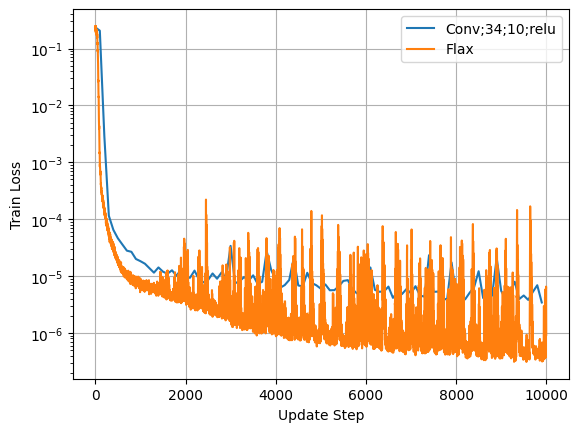

In [19]:
sns.lineplot(data=loss_data, x="update_step", y="train_loss", hue="net")
plt.plot(loss_history, label="Flax")
plt.xlabel("Update Step")
plt.ylabel("Train Loss")
plt.legend()
plt.grid()
plt.yscale("log")

Let's compare the three metric rollouts. Also, here the `flax.nnx` model seems
to dominate!

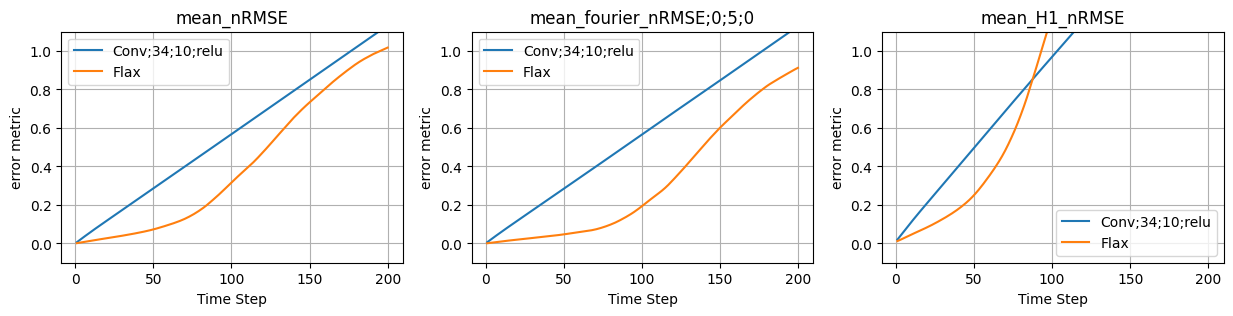

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

for i, metric in enumerate(advection_scenario.report_metrics.split(",")):
    sns.lineplot(data=metric_data, x="time_step", y=metric, hue="net", ax=axs[i])
    axs[i].plot(
        time_steps,
        test_dict[metric][0],
        label="Flax",
    )
    axs[i].legend()
    axs[i].set_title(metric)
    axs[i].set_xlabel("Time Step")
    axs[i].set_ylabel("error metric")
    axs[i].grid()
    axs[i].set_ylim(-0.1, 1.1)

Naturally, this raises the question: are the two networks actually the same? 🤔
Let's compare their parameter counts.

Indeed, this is identical giving us reason to believe they are actually the same
ConvNet just at a different point in the parameter space.

In [21]:
num_params_flax = (
    cnn.conv_lift.kernel.size
    + cnn.conv_lift.bias.size
    + sum(p.kernel.size + p.bias.size for p in cnn.convs)
    + cnn.conv_prj.kernel.size
    + cnn.conv_prj.bias.size
)
num_params_apebench = advection_scenario.get_parameter_count("Conv;34;10;relu")

num_params_flax, num_params_apebench

(31757, 31757)

## Comparing against multiple seeds with APEBench

Let's see if this was just an unlucky seed. To check, we will run multiple
seeds. This is one of the big strengths of APEBench. If a network run, does not
fully utilize the GPU (oftentimes the case in 1D), one can get seed statistics
in parallel for a small overhead.

In [22]:
data_s, trained_net_s = advection_scenario(
    task_config="predict",
    network_config="Conv;34;10;relu",
    train_config="one",
    num_seeds=10,  # Now 10 seeds at the same time
)

E: 00079, B: 00124: 100%|██████████| 10000/10000 [02:03<00:00, 80.78it/s]


Similar melting.

In [23]:
loss_data_s = apebench.melt_loss(data_s)
metric_data_s = apebench.melt_metrics(
    data_s, metric_name=advection_scenario.report_metrics.split(",")
)

Still the `flax.nnx` seems to be better in the one-step error that was used for
training.

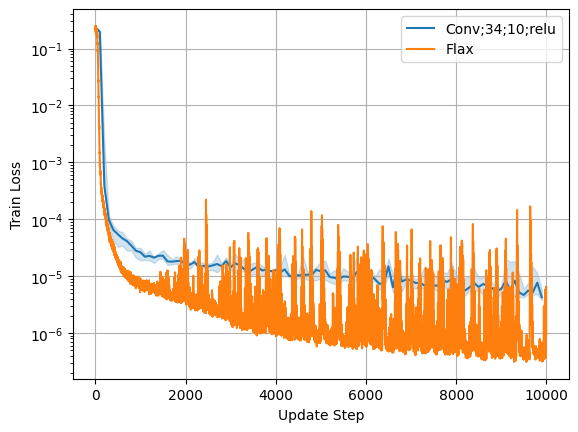

In [24]:
sns.lineplot(
    data=loss_data_s,
    x="update_step",
    y="train_loss",
    hue="net",
    estimator="median",
    errorbar=("pi", 50),
)
plt.plot(loss_history, label="Flax")
plt.xlabel("Update Step")
plt.ylabel("Train Loss")
plt.legend()
plt.grid()
plt.yscale("log")

And this dominance remains for the metric rollout, albeit the APEBench trained
statistics indicate a less severe difference. Yet, it is there.

This is also good motivation why seed statistics are important. Especially for
autoregressive emulators for which errors compound over time, the effect of an
unlucky seed can be especially pronounced.

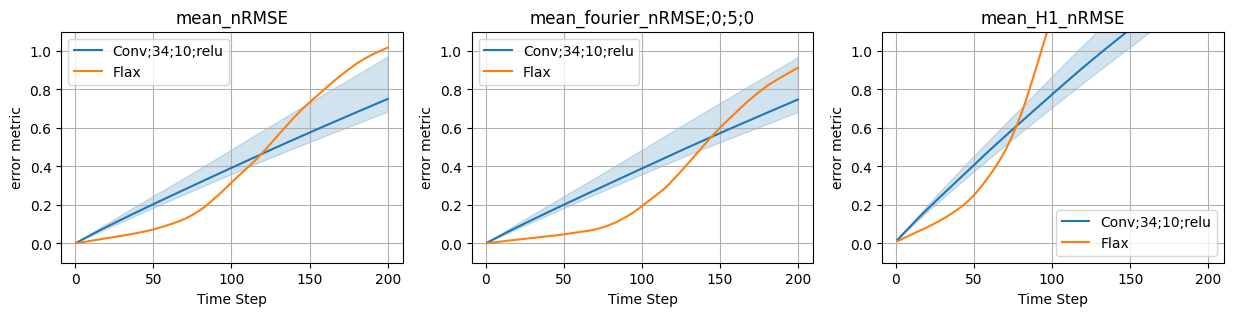

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15, 3))

for i, metric in enumerate(advection_scenario.report_metrics.split(",")):
    sns.lineplot(
        data=metric_data_s,
        x="time_step",
        y=metric,
        hue="net",
        estimator="median",
        errorbar=("pi", 50),
        ax=axs[i],
    )
    axs[i].plot(
        time_steps,
        test_dict[metric][0],
        label="Flax",
    )
    axs[i].legend()
    axs[i].set_title(metric)
    axs[i].set_xlabel("Time Step")
    axs[i].set_ylabel("error metric")
    axs[i].grid()
    axs[i].set_ylim(-0.1, 1.1)

**So what explains the differences?** Likely, this is caused by the different
initialization routines for `flax.nnx` and
[Equinox](https://github.com/patrick-kidger/equinox). The latter follows the
PyTorch conventions, which typically initialize the bias non-zero. For
conservative problems like the advection problem, this can potentially be
disadvantageous.